In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [180]:
file_path = 'ds/DECADQ_74_previous-1950-2022.csv'
data = pd.read_csv(file_path, delimiter=";")

In [181]:
data.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
0,74001001,ABONDANCE,46.2845,6.734167,947,195001,1,78.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,74001001,ABONDANCE,46.2845,6.734167,947,195001,2,24.8,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,74001001,ABONDANCE,46.2845,6.734167,947,195001,3,18.6,9.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,74001001,ABONDANCE,46.2845,6.734167,947,195002,1,83.1,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,74001001,ABONDANCE,46.2845,6.734167,947,195002,2,56.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [182]:
data.describe()

,NUM_POSTE,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,RRAB,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
count,1.315210e+05,131521.000000,131521.000000,131521.000000,131521.000000,131521.000000,126731.000000,126731.000000,131511.000000,126731.000000,...,58070.000000,58070.000000,58070.000000,23946.000000,58129.000000,58129.000000,58129.000000,131511.000000,28550.000000,25922.000000
mean,7.415114e+07,46.042651,6.463336,848.726941,198927.798587,2.000783,38.182292,1.475953,9.695600,17.729551,...,3.835354,20.568538,3.637661,15.257872,2.881660,2.311669,1.551618,1.754751,0.769247,0.695201
std,1.034983e+05,0.167798,0.290198,456.104228,2143.370664,0.816389,35.969416,1.891714,2.071162,14.578754,...,3.826713,44.622368,3.760872,8.911750,4.162301,3.965041,3.440570,3.821451,1.129559,1.298074
min,7.400100e+07,45.713000,5.841667,309.000000,195001.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.405642e+07,45.901667,6.255333,470.000000,197008.000000,1.000000,10.500000,1.000000,10.000000,6.600000,...,1.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.413600e+07,46.013000,6.483333,785.000000,199309.000000,2.000000,29.400000,1.000000,10.000000,15.000000,...,1.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.423600e+07,46.168333,6.692833,1080.000000,200803.000000,3.000000,55.400000,1.000000,10.000000,25.400000,...,9.000000,18.000000,9.000000,22.000000,7.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,7.450000e+07,46.396500,6.970833,3845.000000,202212.000000,3.000000,407.300000,9.000000,11.000000,180.000000,...,9.000000,440.000000,9.000000,31.000000,11.000000,11.000000,11.000000,11.000000,8.000000,11.000000


In [183]:
data = data.drop(data[(data["AAAAMM"] >= 195001) & (data["AAAAMM"] <= 199912)].index)

In [184]:
# Fonction pour formater les dates AAAAMM en AAAA-MM-01
def format_date(aaaamm):
    return re.sub(r'(\d{4})(\d{2})', r'\1-\2-01', str(aaaamm))

# Liste des dates formatées
data["AAAAMM"] = [format_date(val) for val in data["AAAAMM"]]
data.rename(columns={"AAAAMM": "date"}, inplace=True)
data.to_csv("2000_to_2022.csv")

In [185]:
aggregated_data = data.groupby("date").agg({
    'RR': 'sum',          
    'NBJRR10': 'mean',    
    'NBJRR5': 'mean',     
    'NBJRR1': 'mean'      
})

aggregated_df = pd.DataFrame(aggregated_data)

print(aggregated_df)

                 RR   NBJRR10    NBJRR5    NBJRR1
date                                             
2000-01-01   2300.4  0.557377  0.885246  1.409836
2000-02-01   9573.3  1.907104  2.978142  4.781421
2000-03-01   5703.4  1.338798  2.344262  3.273224
2000-04-01   7199.8  1.380435  2.206522  4.076087
2000-05-01   4606.5  0.849398  2.114458  4.144578
...             ...       ...       ...       ...
2022-08-01   3529.4  0.956835  1.553957  2.424460
2022-09-01   7712.3  1.757143  3.228571  5.092857
2022-10-01   6078.7  1.375887  1.893617  3.063830
2022-11-01   6420.3  1.734266  2.349650  4.489510
2022-12-01  10161.3  2.143713  3.131737  4.604790

[276 rows x 4 columns]


In [195]:
aggregated_df = aggregated_df.reset_index()
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
print(aggregated_df)

     index       date       RR   NBJRR10    NBJRR5    NBJRR1
0        0 2000-01-01   2300.4  0.557377  0.885246  1.409836
1        1 2000-02-01   9573.3  1.907104  2.978142  4.781421
2        2 2000-03-01   5703.4  1.338798  2.344262  3.273224
3        3 2000-04-01   7199.8  1.380435  2.206522  4.076087
4        4 2000-05-01   4606.5  0.849398  2.114458  4.144578
..     ...        ...      ...       ...       ...       ...
271    271 2022-08-01   3529.4  0.956835  1.553957  2.424460
272    272 2022-09-01   7712.3  1.757143  3.228571  5.092857
273    273 2022-10-01   6078.7  1.375887  1.893617  3.063830
274    274 2022-11-01   6420.3  1.734266  2.349650  4.489510
275    275 2022-12-01  10161.3  2.143713  3.131737  4.604790

[276 rows x 6 columns]


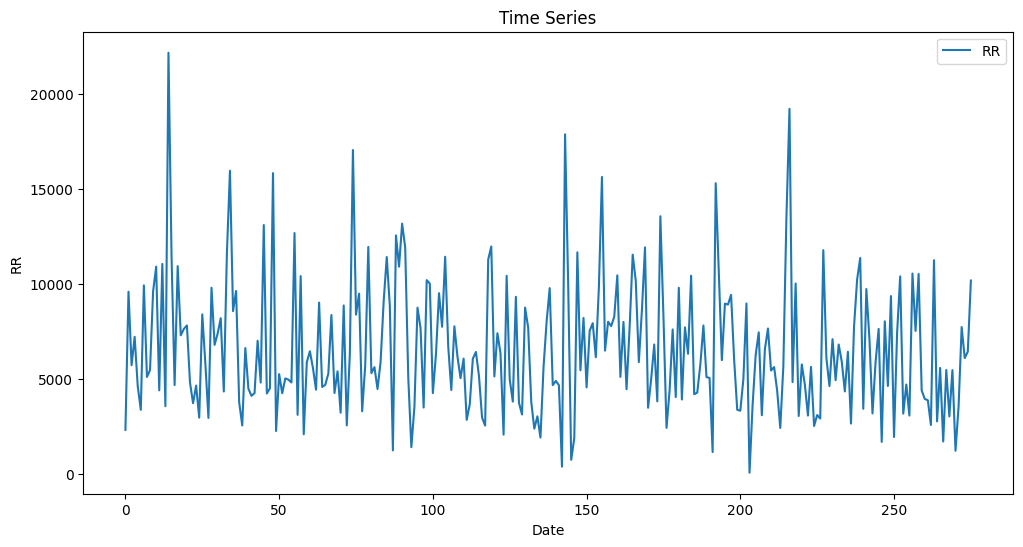

(-16.2223202071784,
 3.8864470318633385e-29,
 0,
 275,
 {'1%': -3.454355055831705,
  '5%': -2.8721080938842976,
  '10%': -2.572401325619835},
 4945.396369816463)

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['RR'], label='RR')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('RR')
plt.legend()
plt.show()

adf_test_result = adfuller(aggregated_df['RR'])

adf_test_result

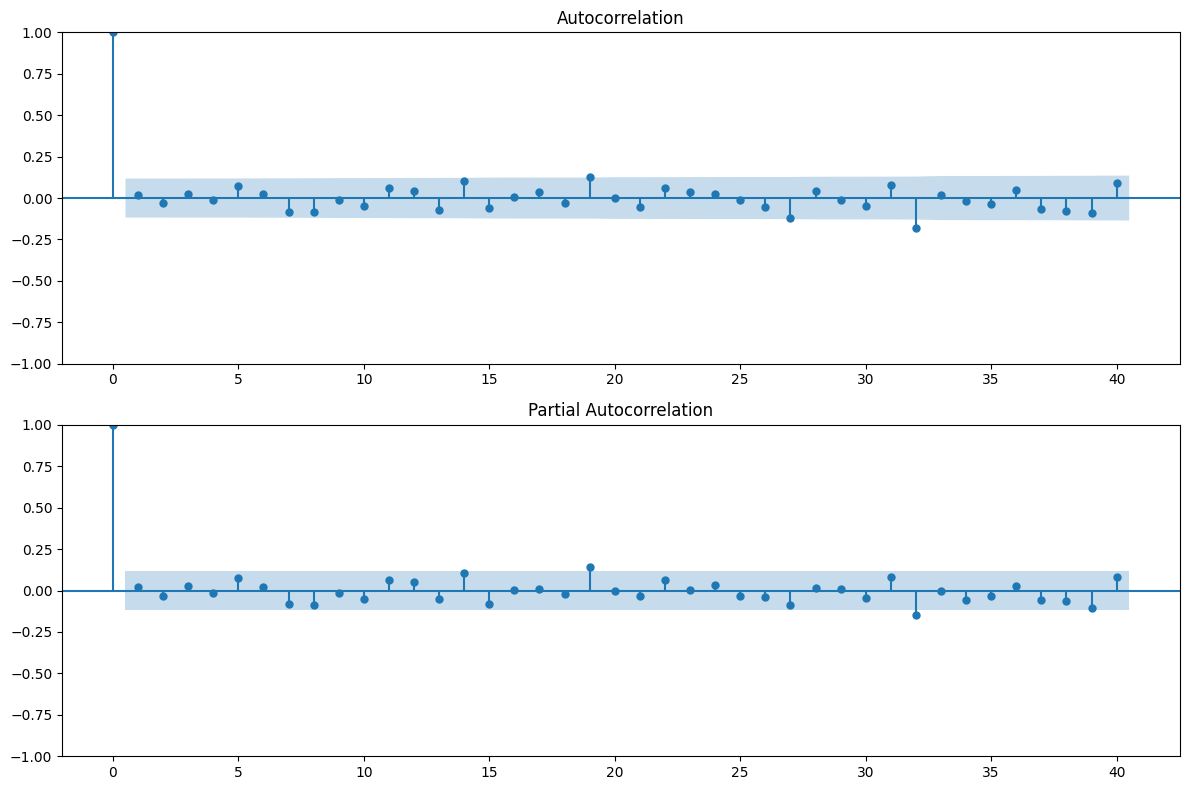

In [188]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(aggregated_df['RR'], ax=ax1, lags=40)

plot_pacf(aggregated_df['RR'], ax=ax2, lags=40)

plt.tight_layout()
plt.show()

In [196]:
train_size = int(len(aggregated_df) * 0.8)
train, test = aggregated_df['RR'][:train_size], aggregated_df['RR'][train_size:]

In [200]:
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

In [201]:
forecast = model_fit.forecast(steps=len(test))

In [202]:
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(rmse)

3002.5444302000215


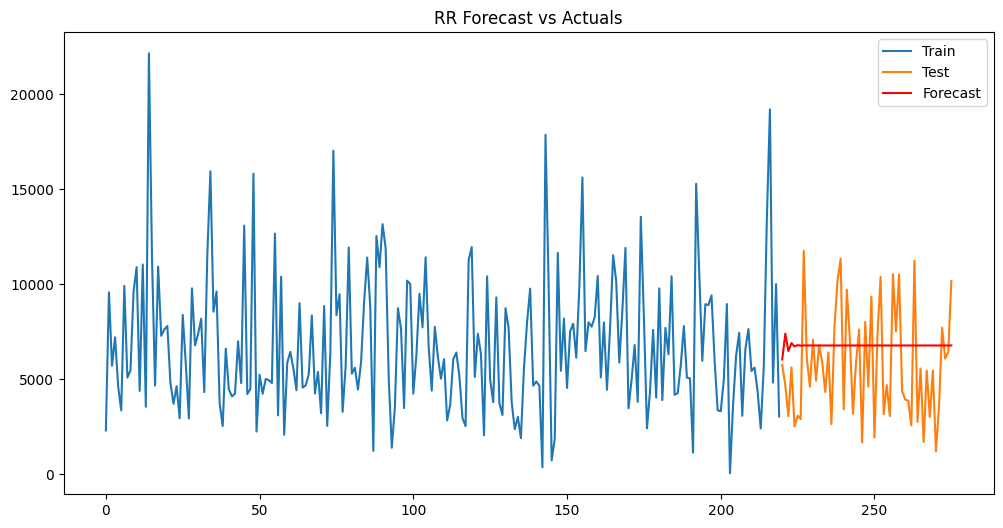

In [203]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('RR Forecast vs Actuals')
plt.legend()
plt.show()

In [194]:
pd.DataFrame(data.groupby(["date"])["RR"].sum())

,RR
date,
2000-01-01,2300.4
2000-02-01,9573.3
2000-03-01,5703.4
2000-04-01,7199.8
2000-05-01,4606.5
...,...
2022-08-01,3529.4
2022-09-01,7712.3
2022-10-01,6078.7
